In [2]:
import sys
import matplotlib.pyplot as plt 
sys.path.append('build')

import cv2 as cv
import bing
import numpy as np

In [3]:
# https://docs.opencv.org/3.4/db/d63/classcv_1_1saliency_1_1ObjectnessBING.html
# Instantiate BING object -> BING('trained model', base_window_size_quantization, window_size, non_maximal_suppress_size)
binger = bing.BING('build/ObjectnessTrainedModel', 2, 8, 2)

img = cv.imread('sample.jpg')
canvas = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)

# Return bounding boxes, in the format of [min_x, min_y, max_x, max_y, score], where the score is already ordered in an ascending order
# Smaller score means higher objectness, which means that it returns objectness in a descending order
# Number of possible bounding boxes depend on the image, where the saliency map of the image is computed using BING saliency detector
bbox = binger.objectness(img)
for b in bbox[:2000]:
    x1, y1, x2, y2 = [int(a) for a in b[:4]]
    s = b[-1]
    # Adding up confidence produced by the bounding box
    canvas[y1:y2, x1:x2] += 1

# Normalize the confidence score and convert it into picture
canvas /= np.max(canvas)
cv.imwrite('sample_result.jpg', canvas * 255)

True

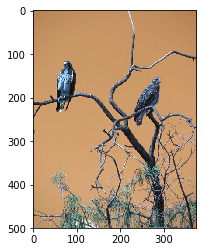

In [3]:
plt.imshow(img)
plt.show()

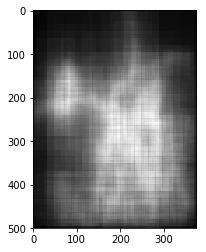

In [4]:
after = cv.imread('sample_result.jpg')
plt.imshow(after)
plt.show()

In [21]:
# UPDATE: It seems that on newer version OpenCV, it is possible to use BING objectness directly in Python without needing a wrapper
model_path = 'build/ObjectnessTrainedModel'

def combine_bb_score(img, model_path, base_window_size_quantization=2, window_size=8, non_maximal_supress_size=2):
    # initialize OpenCV's objectness saliency detector and set the path
    # to the input model files
    saliency = cv.saliency.ObjectnessBING_create()
    saliency.setTrainingPath(model_path)
    saliency.setBase(base_window_size_quantization)
    saliency.setW(window_size)
    saliency.setNSS(non_maximal_supress_size)

    # compute the bounding box predictions used to indicate saliency
    (success, saliencyMap) = saliency.computeSaliency(img)
    
    objectnessScore = saliency.getobjectnessValues() # lower is better
    assert (saliencyMap.shape[0] == objectnessScore.shape[0]), "Saliency map is not equal to Objectness score..Something wrong"
    saliencyMap = saliencyMap.reshape(-1, 4)
    bb_score = np.column_stack((saliencyMap, objectnessScore))
    return bb_score

300.0


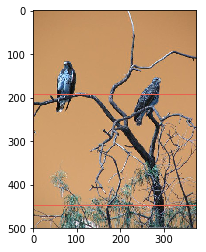

301.0


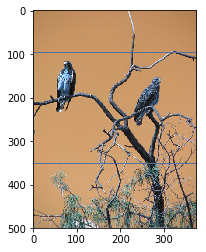

302.0


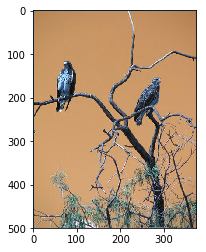

303.0


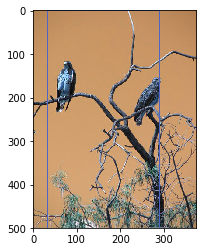

304.0


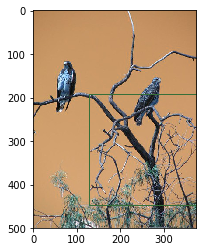

In [23]:
bb_score = combine_bb_score(img, model_path)
numDetections = bb_score.shape[0]
maxDetections = 5  # The number of bounding boxes we want to produce

# loop over the detections to produce individual bounding boxes (ordered from objectness score)
for i in range(0, min(numDetections, maxDetections)):
    # extract the bounding box coordinates
    (startX, startY, endX, endY) = [int(a) for a in bb_score[i][:4]]
    score = bb_score[i][-1]
    print(score) # lower is better
    
    # randomly generate a color for the object and draw it on the image
    output = img.copy()
    color = np.random.randint(0, 255, size=(3,))
    color = [int(c) for c in color]
    cv.rectangle(output, (startX, startY), (endX, endY), color, 2)

    # show the output image
    plt.imshow(output)
    plt.show()